## select search算法

fork from:
https://github.com/AlpacaDB/selectivesearch

In [1]:
import skimage.data

In [2]:
img = skimage.data.camera()

In [3]:
print(type(img))


<class 'numpy.ndarray'>


In [4]:
import numpy as np

In [5]:
img.shape

(512, 512, 3)

In [6]:
from __future__ import division

import skimage.io
import skimage.feature
import skimage.color
import skimage.transform
import skimage.util
import skimage.segmentation
import numpy


# "Selective Search for Object Recognition" by J.R.R. Uijlings et al.
#
#  - Modified version with LBP extractor for texture vectorization


def _generate_segments(im_orig, scale, sigma, min_size):
    """
        segment smallest regions by the algorithm of Felzenswalb and
        Huttenlocher
    """

    # open the Image
    im_mask = skimage.segmentation.felzenszwalb(
        skimage.util.img_as_float(im_orig), scale=scale, sigma=sigma,
        min_size=min_size)

    # merge mask channel to the image as a 4th channel
    im_orig = numpy.append(
        im_orig, numpy.zeros(im_orig.shape[:2])[:, :, numpy.newaxis], axis=2)
    im_orig[:, :, 3] = im_mask

    return im_orig


def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize


def _calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2) + _sim_texture(r1, r2)
            + _sim_size(r1, r2, imsize) + _sim_fill(r1, r2, imsize))


def _calc_colour_hist(img):
    """
        calculate colour histogram for each region
        the size of output histogram will be BINS * COLOUR_CHANNELS(3)
        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]
        extract HSV
    """

    BINS = 25
    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(c, BINS, (0.0, 255.0))[0]])

    # L1 normalize
    hist = hist / len(img)

    return hist


def _calc_texture_gradient(img):
    """
        calculate texture gradient for entire image
        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.
        output will be [height(*)][width(*)]
    """
    ret = numpy.zeros((img.shape[0], img.shape[1], img.shape[2]))

    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret


def _calc_texture_hist(img):
    """
        calculate texture histogram for each region
        calculate the histogram of gradient for each colours
        the size of output histogram will be
            BINS * ORIENTATIONS * COLOUR_CHANNELS(3)
    """
    BINS = 10

    hist = numpy.array([])

    for colour_channel in (0, 1, 2):

        # mask by the colour channel
        fd = img[:, colour_channel]

        # calculate histogram for each orientation and concatenate them all
        # and join to the result
        hist = numpy.concatenate(
            [hist] + [numpy.histogram(fd, BINS, (0.0, 1.0))[0]])

    # L1 Normalize
    hist = hist / len(img)

    return hist


def _extract_regions(img):

    R = {}

    # get hsv image
    hsv = skimage.color.rgb2hsv(img[:, :, :3])

    # pass 1: count pixel positions
    for y, i in enumerate(img):

        for x, (r, g, b, l) in enumerate(i):

            # initialize a new region
            if l not in R:
                R[l] = {
                    "min_x": 0xffff, "min_y": 0xffff,
                    "max_x": 0, "max_y": 0, "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y

    # pass 2: calculate texture gradient
    tex_grad = _calc_texture_gradient(img)

    # pass 3: calculate colour histogram of each region
    for k, v in list(R.items()):

        # colour histogram
        masked_pixels = hsv[:, :, :][img[:, :, 3] == k]
        R[k]["size"] = len(masked_pixels / 4)
        R[k]["hist_c"] = _calc_colour_hist(masked_pixels)

        # texture histogram
        R[k]["hist_t"] = _calc_texture_hist(tex_grad[:, :][img[:, :, 3] == k])

    return R


def _extract_neighbours(regions):

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["min_x"] < a["max_x"]
                and a["min_y"] < b["max_y"] < a["max_y"]) or (
            a["min_x"] < b["max_x"] < a["max_x"]
                and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours


def _merge_regions(r1, r2):
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (
            r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (
            r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt


def selective_search(
        im_orig, scale=1.0, sigma=0.8, min_size=50):
    '''Selective Search
    Parameters
    ----------
        im_orig : ndarray
            Input image
        scale : int
            Free parameter. Higher means larger clusters in felzenszwalb segmentation.
        sigma : float
            Width of Gaussian kernel for felzenszwalb segmentation.
        min_size : int
            Minimum component size for felzenszwalb segmentation.
    Returns
    -------
        img : ndarray
            image with region label
            region label is stored in the 4th value of each pixel [r,g,b,(region)]
        regions : array of dict
            [
                {
                    'rect': (left, top, width, height),
                    'labels': [...],
                    'size': component_size
                },
                ...
            ]
    '''
    assert im_orig.shape[2] == 3, "3ch image is expected"

    # load image and get smallest regions
    # region label is stored in the 4th value of each pixel [r,g,b,(region)]
    img = _generate_segments(im_orig, scale, sigma, min_size)

    if img is None:
        return None, {}

    imsize = img.shape[0] * img.shape[1]
    R = _extract_regions(img)

    # extract neighbouring information
    neighbours = _extract_neighbours(R)

    # calculate initial similarities
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = _calc_sim(ar, br, imsize)

    # hierarchal search
    while S != {}:

        # get highest similarity
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # merge corresponding regions
        t = max(R.keys()) + 1.0
        R[t] = _merge_regions(R[i], R[j])

        # mark similarities for regions to be removed
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)

        # remove old similarities of related regions
        for k in key_to_delete:
            del S[k]

        # calculate similarity set with the new region
        for k in [a for a in key_to_delete if a != (i, j)]:
            n = k[1] if k[0] in (i, j) else k[0]
            S[(t, n)] = _calc_sim(R[t], R[n], imsize)

    regions = []
    for k, r in list(R.items()):
        regions.append({
            'rect': (
                r['min_x'], r['min_y'],
                r['max_x'] - r['min_x'], r['max_y'] - r['min_y']),
            'size': r['size'],
            'labels': r['labels']
        })

    return img, regions

In [18]:
from __future__ import (
    division,
    print_function,
)

import skimage.data
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



def test():

    # loading astronaut image
    img = skimage.data.astronaut()
    
    # perform selective search
    img_lbl, regions = selective_search(
        img, scale=500, sigma=0.9, min_size=10)

    candidates = set()
    for r in regions:
        # excluding same rectangle (with different segments)
        if r['rect'] in candidates:
            continue
        # excluding regions smaller than 2000 pixels
        if r['size'] < 2000:
            continue
        # distorted rects
        x, y, w, h = r['rect']
        if w / h > 1.2 or h / w > 1.2:
            continue
        candidates.add(r['rect'])

    # draw rectangles on the original image
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img)
    for x, y, w, h in candidates:
        print(x, y, w, h)
        rect = mpatches.Rectangle(
            (x, y), w, h, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    plt.show()


In [33]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt


In [36]:
img1 = mpimg.imread('/home/bird.jpg')

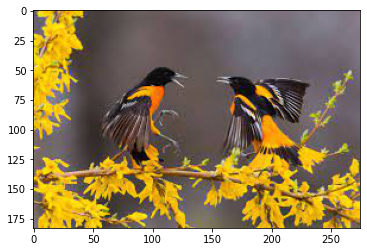

<class 'numpy.ndarray'>


In [37]:
plt.imshow(img1)
plt.show()  
print(type(img1))

In [38]:
img1.shape

(183, 275, 3)

152 17 147 171
46 0 353 326
366 223 93 81
365 345 129 109
364 345 130 109
32 210 207 213
134 348 77 75
255 216 256 295
32 210 207 228
0 210 356 301
42 210 197 213
46 0 353 351
0 0 511 511
111 150 194 198
134 348 75 75
265 216 246 295


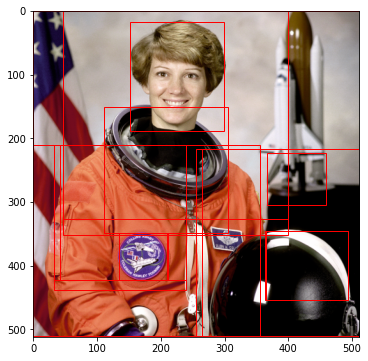

In [19]:
# img = skimage.data.camera()
test()

选择性搜索算法的简介实现

In [26]:
import sys
import cv2


def get_selective_search():
    gs = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    return gs



def get_rects(gs):
    rects = gs.process()
    rects[:, 2] += rects[:, 0]
    rects[:, 3] += rects[:, 1]

    return rects

In [21]:
import urllib

# 下载一张图片

In [35]:
urlStr = 'https://www.google.com.hk/imgres?imgurl=http%3A%2F%2Fa4.mzstatic.com%2Fus%2Fr1000%2F046%2FPurple%2Fbd%2F8f%2Ffd%2Fmzl.emkswtfe.jpg&imgrefurl=http%3A%2F%2Fmis-discos.blogspot.com%2F2014%2F05%2Fdomestic-cat-pictures.html&tbnid=-4fBO0pdj1X-tM&vet=12ahUKEwiU98is89bvAhXZA6YKHeB0BWoQMygBegUIARDGAQ..i&docid=Cg8QwbyKPx2YWM&w=512&h=512&q=cat%20%20%20512%20&safe=strict&ved=2ahUKEwiU98is89bvAhXZA6YKHeB0BWoQMygBegUIARDGAQ'
 
urllib.request.urlretrieve(urlStr , filename='/home/cat.png')


('/home/cat.png', <http.client.HTTPMessage at 0x7f68b2d319d0>)